
# N-Particle DVR Implementation in 1D with Periodic Boundary Conditions

**Sections:**
1. Setting parameters  
2. Building the DVR grid and plane-wave basis  
3. Constructing the potential matrix  
4. Constructing the kinetic energy matrix  
5. Hamiltonian assembly and checks  
6. Solving for eigenvalues and visualizing energy levels


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from itertools import product

## Step 1 — Setting Parameters  
📖 *Reference: Section 3.1 (before Eq. 23)*

Define the physical and numerical parameters for simulating $N$-particle in 1D (DVR) method.

### Key Parameters:
- $N$: Number of particles  
- $L$: Length of the 1D periodic box  
- $n$: Number of DVR grid points per coordinate (must be even)  
- $\mu$: Reduced mass for kinetic energy terms (for equal-mass particles, $\mu = m/2$)

### Derived Quantities:
- **Grid spacing:**  
  $$\Delta x = \frac{L}{n}$$

- **Momentum space values (Eq. 23):**  
  $$p_j = \frac{2\pi j}{L}, \quad \text{where } j = -\frac{n}{2}, \dots, \frac{n}{2} - 1$$

- **DVR mesh points (Eq. 33):**  
  $$x_k = \frac{L}{n} \cdot k, \quad \text{with } k = -\frac{n}{2}, \dots, \frac{n}{2} - 1$$

- **Total Hilbert space dimension (for DVR in relative coordinates):**  
  $$\text{dim}(\mathcal{H}) = n^{N-1}$$

These quantities will define the DVR basis used throughout the rest of the implementation.

In [2]:
# === Step 1: Setting Parameters ===

# Simulation parameters
N = 3                # Number of particles (adjustable)
n_pts = 16           # DVR grid points per coordinate (must be even for symmetry)
L = 10.0             # Length of the 1D periodic box
mass = 1.0           # Mass of each particle (set to 1 in natural units)
mu = mass / 2        # Reduced mass for two-body interactions

# Potential parameters
V0 = -5.0            # Depth of Gaussian potential
R = 1.0              # Range (width) of Gaussian potential

# Derived DVR grid quantities
dx = L / n_pts                                   # Grid spacing
x_vals = np.linspace(-L/2, L/2 - dx, n_pts)      # DVR grid points in real space (Eq. 33)
p_vals = 2 * np.pi * np.fft.fftfreq(n_pts, d=dx) # Plane-wave momenta (Eq. 23)

# === Sanity check printouts ===
print("Number of particles (N):", N)
print("Grid points per dimension (n):", n_pts)
print("Box length (L):", L)
print("Grid spacing (dx = L/n):", dx)
print("Hilbert space dimension (n^(N-1)):", n_pts**(N-1))
print("\nFirst few x grid points:")
print(x_vals[:5])
print("\nFirst few p values:")
print(p_vals[:5])

Number of particles (N): 3
Grid points per dimension (n): 16
Box length (L): 10.0
Grid spacing (dx = L/n): 0.625
Hilbert space dimension (n^(N-1)): 256

First few x grid points:
[-5.    -4.375 -3.75  -3.125 -2.5  ]

First few p values:
[0.         0.62831853 1.25663706 1.88495559 2.51327412]


## Step 2 — DVR Basis and Plane-Wave Grid  
📖 *Reference: König, Section 3.1 (Eqs. 23–35)*

We now construct the **plane-wave basis** and the **DVR transformation matrix** $U$ used to switch between the plane-wave representation and the DVR grid.

In this framework, the DVR is built from periodic plane waves of the form (Eq. 23):
$$
\phi_j(x) = \frac{1}{\sqrt{L}} e^{i p_j x}, \quad \text{where} \quad p_j = \frac{2\pi j}{L}
$$

To construct the DVR transformation matrix, we evaluate these basis functions at the DVR grid points $x_k$ (Eq. 33):
$$
x_k = \frac{L}{n} \cdot k, \quad \text{for } k = -\frac{n}{2}, \dots, \frac{n}{2}-1
$$

Then we build the transformation matrix $U_{kj}$:
$$
U_{kj} = \frac{1}{\sqrt{n}} e^{i p_j x_k} \tag{Eq. 35}
$$

This matrix diagonalizes local position-dependent operators in the DVR basis. It is unitary (i.e., $U^\dagger U = I$), and it forms the basis for evaluating operators such as the kinetic energy.

---

The matrix $U$ has shape:
- $(n \times n)$ for 1D
- $(n^{N-1} \times n^{N-1})$ when extended via Kronecker products in $N$-particle DVR

In [3]:
# Compute the transformation matrix:
# Each element corresponds to U[k, j] = (1/√n) * e^(i * p_j * x_k)
U = np.exp(1j * np.outer(x_vals, p_vals)) / np.sqrt(n_pts)

# Optional: verify shape and structure
print("Shape of U matrix:", U.shape)
print("First few elements of real part (U):")
print(np.real(U[:3, :3]))

Shape of U matrix: (16, 16)
First few elements of real part (U):
[[ 2.50000000e-01 -2.50000000e-01  2.50000000e-01]
 [ 2.50000000e-01 -2.30969883e-01  1.76776695e-01]
 [ 2.50000000e-01 -1.76776695e-01 -4.59242550e-17]]


## 3. Potential Energy Matrix

## Step 3 — Potential Energy Matrix  
📖 *Reference: König, Section 3.2 (Eqs. 25 and 40)*

Now we build the **potential energy matrix** in the DVR basis for an $N$-particle system.  
The particles interact through **pairwise Gaussian potentials**, and the system lives in a 1D periodic box, so we have to apply the **minimum image convention**.

---

### Local Potential (Eq. 25)

The two-body interaction potential is modeled as a Gaussian:
$$
V(x) = V_0 \, \exp\left( -\left( \frac{x}{R} \right)^2 \right)
$$

- $V_0$: Depth (typically negative for attraction)
- $R$: Range of the potential

This function is **even** and **short-ranged**

---

### DVR Approximation for Local Operators (Eq. 40)

Because DVR basis functions are **localized**, position-dependent operators like $V(x)$ become approximately **diagonal**:
$$
\langle \psi_k | \hat{V} | \psi_l \rangle \approx V(x_k) \, \delta_{kl}
\tag{Eq. 40}
$$

In the $N$-body DVR grid, this means we only need to compute the **diagonal values** of the potential matrix at each grid point in configuration space.

---

### Minimum Image Convention 

Since our system is **periodic**, we must use the **minimum image convention** to compute pairwise distances:
$$
r_{ij} = x_i - x_j - L \cdot \text{round}\left( \frac{x_i - x_j}{L} \right)
$$

This ensures all pairwise separations lie in the range $[-L/2, L/2]$

---

### Computational Implementation

- Loop over all DVR grid points in $(N-1)$-dimensional configuration space
- For each configuration, compute all pairwise separations $r_{ij}$
- Apply the Gaussian potential to each $r_{ij}$
- Store the **sum** of all pairwise potentials on the **diagonal** of the potential matrix

The result is a **flat array of length** $n^{N-1}$ containing the diagonal values of $\hat{V}$ in the DVR basis.

In [4]:
# ---------------- Potential Function ----------------

def V_gaussian(x, V0=V0, R=R):
    return V0 * np.exp(- (x / R)**2)


# ---------------- Build Potential Matrix ----------------

def build_potential_Nbody(N, x_vals, L=L):
    shape = (n_pts,) * (N - 1)           # DVR shape for (N−1) relative coords
    V_diag = np.zeros(shape)             # Initialize diagonal of potential matrix

    for idx in np.ndindex(shape):        # Loop over all grid configurations
        coords = [x_vals[i] for i in idx]
        V = 0.0
        for i in range(len(coords)):     # Loop over all i < j pairs
            for j in range(i + 1, len(coords)):
                r_ij = coords[i] - coords[j]
                r_ij -= L * np.round(r_ij / L)    # Minimum image convention
                V += V_gaussian(r_ij)
        V_diag[idx] = V

    return V_diag.flatten()


# ---------------- Execute and Check ----------------

V_dvr = build_potential_Nbody(N, x_vals)

print("Shape of V_dvr:", V_dvr.shape)
print("First 5 values:", V_dvr[:5])

Shape of V_dvr: (256,)
First 5 values: [-5.         -3.38316923 -1.04805694 -0.14864608 -0.00965227]


## 4. Kinetic Energy Matrix

## Step 4 — Kinetic Energy Matrix  
📖 *Reference: König, Section 3.3 (Eq. 38)*

We now construct the **kinetic energy operator** $\hat{T}$ in the DVR basis.

---

### Matrix Elements (Eq. 38)

In DVR, the kinetic energy matrix is **not diagonal**, but it has an analytic form derived from the second derivative operator in the plane-wave basis:

For 1D, the matrix elements are:
$$
T_{kl} =
\begin{cases}
\frac{\pi^2 n^2}{6 \mu L^2} \left(1 + \frac{2}{n^2} \right), & k = l \\[10pt]
\frac{(-1)^{k - l} \pi^2}{\mu L^2 \sin^2 \left( \frac{\pi (k - l)}{n} \right)}, & k \neq l
\end{cases}
\tag{Eq. 38}
$$

- $\mu$ is the reduced mass
- $n$ is the number of DVR points
- $L$ is the box length

This results in a dense symmetric matrix $T^{(1D)}$ of size $n \times n$.

---

### Kronecker Sums for Higher Dimensions

To generalize the 1D kinetic matrix to the full $(N-1)$-dimensional DVR space, we build the total kinetic energy as a **Kronecker sum**:

$$
\hat{T}^{(N-1)} = \sum_{i=1}^{N-1} \mathbb{I} \otimes \cdots \otimes T^{(1D)} \otimes \cdots \otimes \mathbb{I}
$$

Where:
- $T^{(1D)}$ appears once in each summand at the $i^{th}$ position,
- $\mathbb{I}$ is the identity matrix of size $n \times n$.

This builds a full kinetic matrix of size $n^{N-1} \times n^{N-1}$.

In [5]:
# ---------------- Kinetic Energy Matrix (1D) ----------------

def kinetic_energy_matrix(n, L, mu):
    T = np.zeros((n, n))                              # Initialize empty n x n kinetic energy matrix
    for k in range(n):
        for l in range(n):
            if k == l:
                # Diagonal term (k = l), Eq. (38)
                T[k, l] = (np.pi**2 * n**2) / (6 * mu * L**2) * (1 + 2 / n**2)
            else:
                # Off-diagonal terms (k ≠ l), Eq. (38)
                delta = k - l
                T[k, l] = ((-1)**delta) * (np.pi**2) / (mu * L**2 * np.sin(np.pi * delta / n)**2)
    return T

T_1d = kinetic_energy_matrix(n_pts, L, mu)            # Build 1D kinetic matrix

print("T_1d shape:", T_1d.shape)                      # Check matrix size
print("First 3 diagonal elements of T_1d:", np.diag(T_1d)[:3])  # Sanity check
print("T_1d is Hermitian:", np.allclose(T_1d, T_1d.T.conj()))   # Verify symmetry


# ---------------- Build Kinetic Matrix for (N−1)D ----------------

def build_kinetic_ND(N, T_1d):
    T_full = None                                      # Will hold the full Kronecker-sum kinetic matrix
    for i in range(N - 1):                             # Loop over each coordinate axis
        ops = [np.eye(n_pts) for _ in range(N - 1)]    # Build list of identity matrices
        ops[i] = T_1d                                   # Replace one identity with T_1d on the i-th axis

        Ti = ops[0]                                     # Start with the first operator
        for op in ops[1:]:                              # Kronecker product with remaining ops
            Ti = np.kron(Ti, op)

        T_full = Ti if T_full is None else T_full + Ti  # Sum across all directions (Kronecker sum)

    return T_full

T_dvr = build_kinetic_ND(N, T_1d)                      # Build full kinetic matrix in (N−1)D DVR space

print("T_dvr shape:", T_dvr.shape)                     # Should be (n^(N−1), n^(N−1))
print("First 5 diagonal entries of T_dvr:", np.diag(T_dvr)[:5])  # Inspect structure

T_1d shape: (16, 16)
First 3 diagonal elements of T_1d: [8.48785978 8.48785978 8.48785978]
T_1d is Hermitian: True
T_dvr shape: (256, 256)
First 5 diagonal entries of T_dvr: [16.97571957 16.97571957 16.97571957 16.97571957 16.97571957]


## 5. Hamiltonian and Sanity Checks

## Step 5 — Hamiltonian and Sanity Checks  
📖 *Reference: König, Section 3.3 (implicit after Eq. 38)*

We now assemble the full **Hamiltonian** operator in the DVR basis:
$$
\hat{H} = \hat{T} + \hat{V}
$$

- $\hat{T}$: Kinetic energy matrix (dense)
- $\hat{V}$: Potential energy matrix (diagonal)

Since the DVR method approximates $\hat{V}$ as diagonal and $\hat{T}$ is analytically known from Eq. (38), the total Hamiltonian is computable.

---

### Sanity Checks:
Before proceeding to solve the eigenvalue problem, we verify that:
- $\hat{H}$ is **Hermitian**:  
  $H = H^\dagger$
- Its shape is consistent with the expected DVR Hilbert space:  
  $n^{N-1} \times n^{N-1}$


In [19]:
# ---------------- Build Hamiltonian ----------------

V_matrix = np.diag(V_dvr)                 # Convert flattened potential array into diagonal matrix
H = T_dvr + V_matrix                      # Construct full Hamiltonian H = T + V

# ---------------- Sanity Checks ----------------

print("Hermitian check:", np.allclose(H, H.conj().T))   # Ensure H is Hermitian (H = H†)
print("Hamiltonian shape:", H.shape)                    # Confirm expected size (n^(N−1) × n^(N−1))
print("Min energy element (H):", np.min(H))             # Check minimum value for scale sanity
print("Max energy element (H):", np.max(H))             # Check maximum value


Hermitian check: True
Hamiltonian shape: (256, 256)
Min energy element (H): -5.186307823216022
Max energy element (H): 16.975719569804255


## 6. Solving the Eigenvalue Problem

## Step 6 — Solving the Eigenvalue Problem  
📖 *Reference: König, Section 3.3 (following Eq. 38)*

With the Hamiltonian matrix $\hat{H}$ constructed, we now solve the **time-independent Schrödinger equation**:
$$
\hat{H} \psi_n = E_n \psi_n
$$

This step yields:
- $E_n$: Energy eigenvalues (sorted from lowest to highest)
- $\psi_n$: Eigenvectors representing the wavefunctions in the DVR basis

---

### Numerical Method

We use `scipy.linalg.eigh`, for diagonalizing **Hermitian matrices**.  
This method guarantees **real** eigenvalues and **orthonormal** eigenvectors.

- The result is a full spectrum of eigenstates.
- We focus on the **lowest 5–10 states**.

---

### Physical Interpretation

- Each $E_n$ is a possible **energy level** of the $N$-body quantum system.
- Each $\psi_n$ is the corresponding **wavefunction**, defined over the DVR grid.


In [20]:
# ---------------- Solve the Eigenvalue Problem ----------------

E, psi = eigh(H)                           # Diagonalize Hamiltonian: H ψ = E ψ
                                          # E: eigenvalues (energies), psi: eigenvectors (wavefunctions)

# ---------------- Print Results ----------------

print("Lowest 10 energy levels:")         # Print first 10 sorted energy levels
for i in range(10):
    print(f"E[{i}] = {E[i]:.6f}")

print("Eigenvector shape:", psi.shape)   # Each column psi[:, i] is the i-th eigenstate
print("First 5 entries of ground state:", psi[:, 0][:5])  # Sanity check on ψ₀

Lowest 10 energy levels:
E[0] = -2.581829
E[1] = -2.383985
E[2] = -2.383985
E[3] = -1.792292
E[4] = -1.792292
E[5] = -0.804948
E[6] = -0.804948
E[7] = 0.224220
E[8] = 0.224220
E[9] = 0.302536
Eigenvector shape: (256, 256)
First 5 entries of ground state: [-0.14828848 -0.11847556 -0.06813356 -0.03447109 -0.01701733]


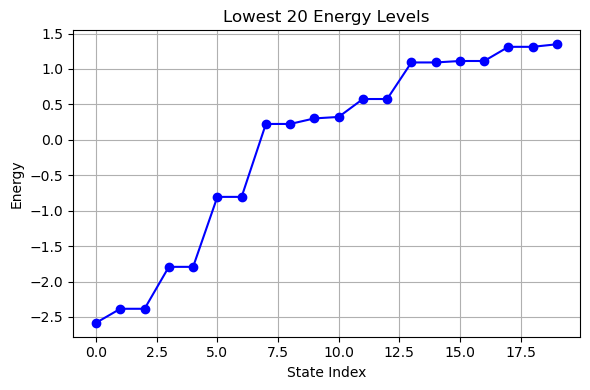

In [21]:
# ---------------- Energy Level Spectrum ----------------

plt.figure(figsize=(6, 4))
plt.plot(np.arange(20), E[:20], 'bo-', label='Energy levels')
plt.xlabel("State Index")
plt.ylabel("Energy")
plt.title("Lowest 20 Energy Levels")
plt.grid(True)
plt.tight_layout()
plt.show()

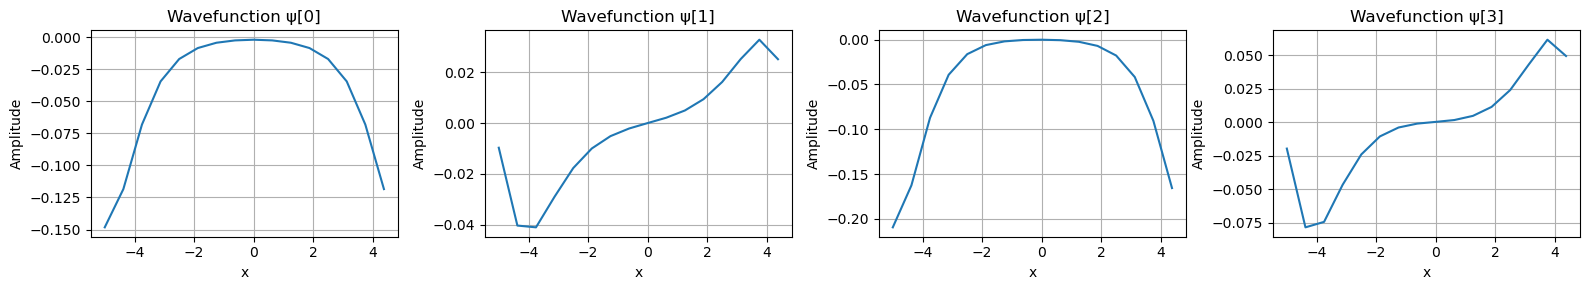

In [22]:
# ---------------- Wavefunction Visualization ----------------

n_states_to_plot = 4                          # Number of lowest states to visualize
grid_shape = (n_pts,) * (N - 1)               # Shape of DVR grid

# x-axis for 1D slice visualization (e.g., fix all but one coord)
x_plot = x_vals                               # x-axis for plotting 1D slices

fig, axes = plt.subplots(1, n_states_to_plot, figsize=(16, 3))

for i in range(n_states_to_plot):
    # Extract and reshape i-th eigenvector (wavefunction)
    psi_i = psi[:, i].reshape(grid_shape)
    
    # Plot 1D slice (along first coordinate, others fixed at 0-index)
    psi_slice = psi_i[:, *(0,) * (N - 2)]     # Fix all but one dimension
    axes[i].plot(x_plot, psi_slice.real, label=f"$\psi_{i}(x)$")
    axes[i].set_title(f"Wavefunction ψ[{i}]")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("Amplitude")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

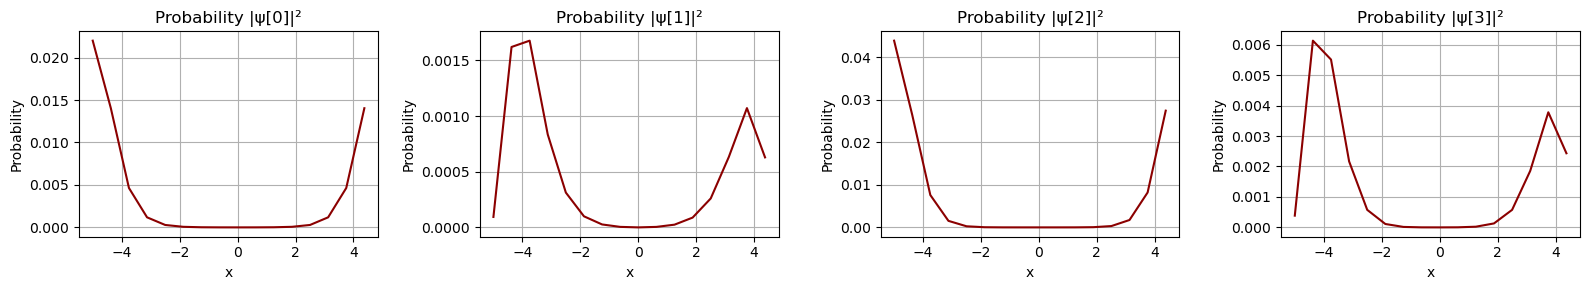

In [23]:
# ---------------- Probability Density ----------------

fig, axes = plt.subplots(1, n_states_to_plot, figsize=(16, 3))

for i in range(n_states_to_plot):
    psi_i = psi[:, i].reshape(grid_shape)
    psi_slice = psi_i[:, *(0,) * (N - 2)]     # Fix other dimensions
    prob_density = np.abs(psi_slice)**2
    axes[i].plot(x_plot, prob_density, color='darkred')
    axes[i].set_title(f"Probability |ψ[{i}]|²")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("Probability")
    axes[i].grid(True)

plt.tight_layout()
plt.show()